In [142]:
from matplotlib.ticker import FuncFormatter,FixedLocator
import pandas as pd
import matplotlib.pyplot as plt
from unidecode import unidecode
plt.style.use("fivethirtyeight")

In [143]:
from pyspark.sql import SparkSession 

sc = SparkSession.builder.appName("Visualizando").config("spark.driver.memory", "8g").getOrCreate()

In [144]:
import pyspark.sql.functions as F

DATA_PATH = "/app/data/"
input_file = DATA_PATH+"dados_log_urna/" 

df = sc.read.parquet(input_file)

df.show()

+--------------------+----------+-------------------+------------------+---------+--------------+---------------+---------------+----------------+---------------+----------------+
|             arquivo|id_eleitor|               data|         descricao|Municipio|Zona_Eleitoral|Secao_Eleitoral|erros_ate_agora|sum(erros_tecla)|tempo(segundos)|erro_nesse_cargo|
+--------------------+----------+-------------------+------------------+---------+--------------+---------------+---------------+----------------+---------------+----------------+
|file:///app/data/...|        22|2022-10-02 09:23:22|  Deputado Federal|    16004|            21|             16|              1|               6|             25|               1|
|file:///app/data/...|        22|2022-10-02 09:24:04| Deputado Estadual|    16004|            21|             16|              4|               6|             42|               3|
|file:///app/data/...|        22|2022-10-02 09:24:39|           Senador|    16004|            21|   

# Teclas Erradas

In [145]:
def plot_box(dados, titulo, salvar, showfliers):
    com_sem = "sem"
    if showfliers:
        com_sem = "com"

    plt.style.use("fivethirtyeight")
    plt.figure(figsize=(10, 6))
    plt.boxplot(dados, showfliers=showfliers)

    plt.title(f"{titulo} ({com_sem} outlier)")
    plt.xticks([]) 
    plt.grid(True)

    if salvar:
        nome_arquivo = unidecode(titulo).lower().replace(" ", "_")
        plt.savefig(f"app/img/box_{nome_arquivo}_outlier.jpg", format="jpg")
    plt.show()

In [146]:
erros = (
    df.groupby("arquivo", "id_eleitor")
    .max("sum(erros_tecla)")
    .select(F.col("max(sum(erros_tecla))").alias("max_erros"))
    .toPandas()
)
erros

,max_erros
0,2
1,4
2,0
3,0
4,0
...,...
2082090,6
2082091,1
2082092,1
2082093,1


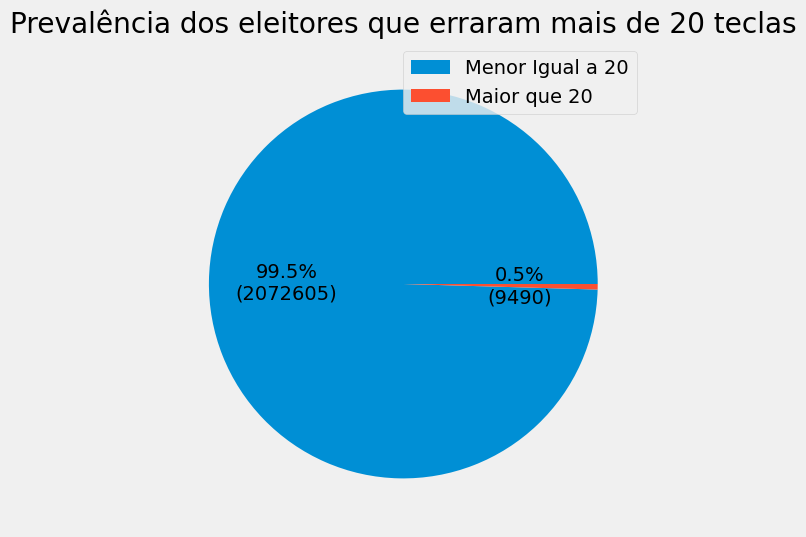

In [147]:
titulo = "Prevalência dos eleitores que erraram mais de 20 teclas"
df_pie = erros["max_erros"]
df_pie = (df_pie <= 20).value_counts()
plt.figure(figsize=(10, 6))
plt.pie(df_pie, autopct=lambda pct: f'{pct:.1f}%\n({int(pct/100.*sum(df_pie))})')
plt.legend(loc="best",labels=['Menor Igual a 20', 'Maior que 20']) 
plt.title(titulo)
nome_arquivo = unidecode(titulo).lower().replace(" ", "_")
plt.savefig(f"app/img/pie_{nome_arquivo}.jpg", format="jpg")
plt.show()
del df_pie

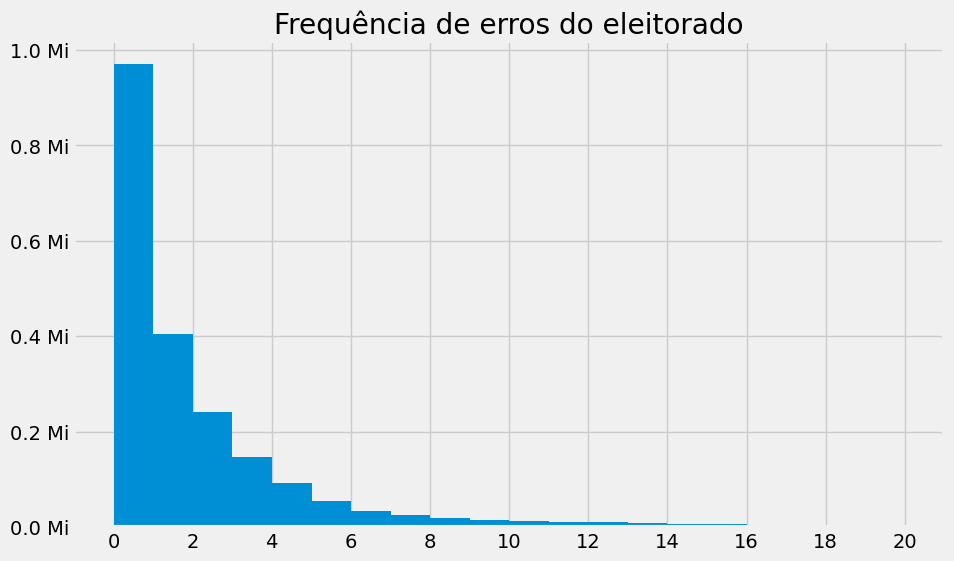

In [148]:
def millions_formatter(x, pos):
    return '{:.1f} Mi'.format(x * 1e-6)
titulo = "Frequência de erros do eleitorado"
nome_arquivo = unidecode(titulo).lower().replace(" ", "_")

df_hist = erros["max_erros"]
df_hist = df_hist[df_hist <= 20]
plt.figure(figsize=(10, 6))
plt.hist(df_hist,bins=20)
plt.title(titulo)
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))
plt.gca().xaxis.set_major_locator(FixedLocator([i for i in range(0,21,2)]))

plt.savefig(f"app/img/hist_{nome_arquivo}.jpg", format="jpg")
del df_hist
plt.show()

## Erros por Cargo

In [149]:
erro_por_cargo = df.groupBy("descricao", "erro_nesse_cargo").count().toPandas()
erro_por_cargo = erro_por_cargo.pivot_table(index='erro_nesse_cargo', columns='descricao', values='count', aggfunc='sum').fillna(0)
erro_por_cargo = erro_por_cargo.loc[erro_por_cargo.index <=5 ]
erro_por_cargo

descricao,Deputado Estadual,Deputado Federal,Governador,Presidente,Senador
erro_nesse_cargo,,,,,
0,1621197.0,1709110.0,1563879.0,1639932.0,1564191.0
1,324476.0,233251.0,431356.0,395747.0,341240.0
2,60349.0,43489.0,34832.0,21739.0,76902.0
3,22742.0,17341.0,32866.0,14198.0,47720.0
4,29580.0,11353.0,6102.0,3696.0,18170.0
5,7538.0,14252.0,2914.0,1907.0,9956.0


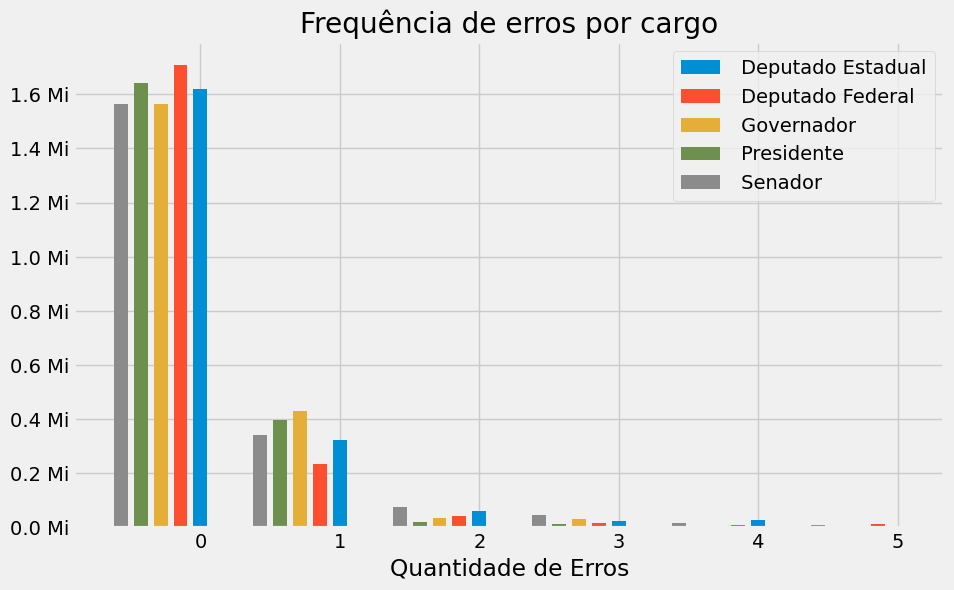

In [150]:
import numpy as np
def millions_formatter(x, pos):
    return '{:.1f} Mi'.format(x * 1e-6)
count = 0
x_axis = erro_por_cargo.index*(len(erro_por_cargo.columns)+2)
plt.figure(figsize=(10, 6))
for col in erro_por_cargo.columns:
    plt.bar(x_axis - count, erro_por_cargo[col], 0.7, label = col) 
    count+=1
  

plt.xticks(x_axis, erro_por_cargo.index) 
plt.xlabel("Quantidade de Erros") 
titulo = "Frequência de erros por cargo"
plt.title(titulo) 
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))


nome_arquivo = unidecode(titulo).lower().replace(" ", "_")
plt.legend()
plt.savefig(f"app/img/bar_{nome_arquivo}.jpg", format="jpg")
 
plt.show() 

# Tempo de Votação

In [151]:
tempoDeVotacao = (
    df.groupBy("arquivo", "id_eleitor")
    .sum("tempo(segundos)")
    .select("sum(tempo(segundos))")
    .withColumnRenamed("sum(tempo(segundos))", "Tempo de Votação (Segundos)")
)
df_tempoDeVotacao = tempoDeVotacao.toPandas()
df_tempoDeVotacao

,Tempo de Votação (Segundos)
0,77
1,201
2,98
3,73
4,61
...,...
2082090,57
2082091,43
2082092,45
2082093,38


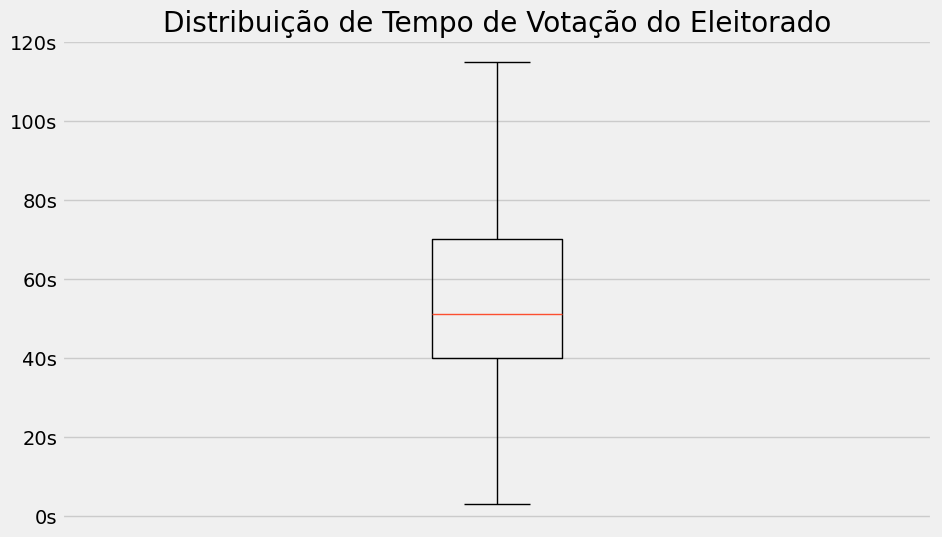

In [155]:
titulo = "Distribuição de Tempo de Votação do Eleitorado"
nome_arquivo = unidecode(titulo).lower().replace(" ", "_")

plt.figure(figsize=(10, 6))
box = plt.boxplot(df_tempoDeVotacao["Tempo de Votação (Segundos)"], showfliers=False)
plt.title(titulo)

def segundo_formatar(x, pos):
    return '{:.0f}s'.format(x)

plt.gca().yaxis.set_major_formatter(FuncFormatter(segundo_formatar))

plt.xticks([])
plt.savefig(f"app/img/box_{nome_arquivo}.jpg", format="jpg")
plt.show()

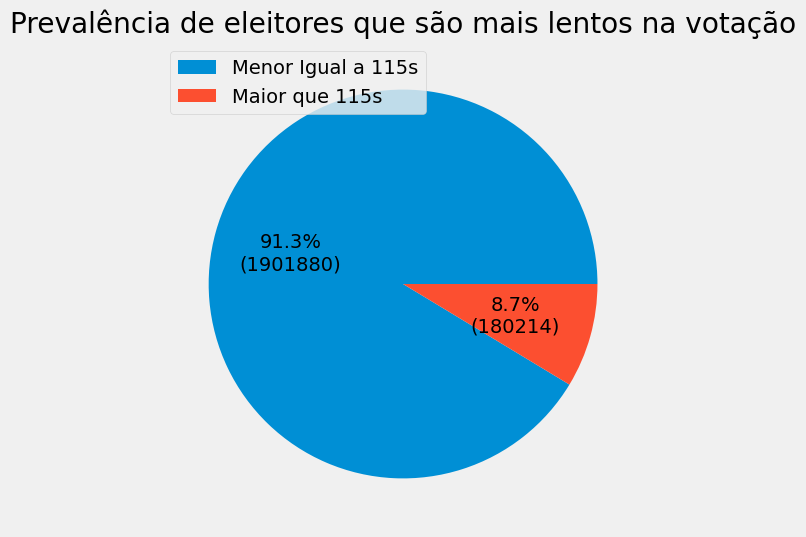

In [153]:
titulo = "Prevalência de eleitores que são mais lentos na votação"
df_pie = df_tempoDeVotacao["Tempo de Votação (Segundos)"]

limite_superior = box['whiskers'][1].get_ydata()[1]
limite_superior
df_pie = (df_pie <= limite_superior).value_counts()
plt.figure(figsize=(10, 6))
plt.pie(df_pie, autopct=lambda pct: f'{pct:.1f}%\n({int(pct/100.*sum(df_pie))})')
plt.legend(loc="best",labels=[f'Menor Igual a {limite_superior:.0f}s', f'Maior que {limite_superior:.0f}s']) 
plt.title(titulo)
nome_arquivo = unidecode(titulo).lower().replace(" ", "_")
#plt.savefig(f"app/img/pie_{nome_arquivo}.jpg", format="jpg")
plt.show()
del df_pie

# Tempo de votação por cargo

In [163]:
erro_por_cargo = (
    df.groupBy("descricao")
    ).agg(
    F.percentile_approx("tempo(segundos)", [0.25, 0.5, 0.75],1000).alias("percentil"))

# Create new columns from the array column
for i,k in  zip([0.25, 0.5, 0.75],range(3)):
    erro_por_cargo = erro_por_cargo.withColumn(f"percentil_{round(i*100)}", F.col("percentil")[k])
erro_por_cargo = erro_por_cargo.withColumn("IQ", F.col("percentil_75") - F.col("percentil_25"))
erro_por_cargo = erro_por_cargo.withColumn("min", (F.col("percentil_25") - F.col("IQ")*1.5))
erro_por_cargo = erro_por_cargo.withColumn("min", F.when(F.col("min") < 0, 0).otherwise(F.col("min")))
erro_por_cargo = erro_por_cargo.withColumn("max", F.col("percentil_75") + F.col("IQ")*1.5)
erro_por_cargo = erro_por_cargo.toPandas()
erro_por_cargo

,descricao,percentil,percentil_25,percentil_50,percentil_75,IQ,min,max
0,Presidente,"[4, 6, 8]",4,6,8,4,0.0,14.0
1,Deputado Estadual,"[8, 10, 15]",8,10,15,7,0.0,25.5
2,Governador,"[5, 6, 9]",5,6,9,4,0.0,15.0
3,Senador,"[6, 8, 12]",6,8,12,6,0.0,21.0
4,Deputado Federal,"[13, 17, 25]",13,17,25,12,0.0,43.0


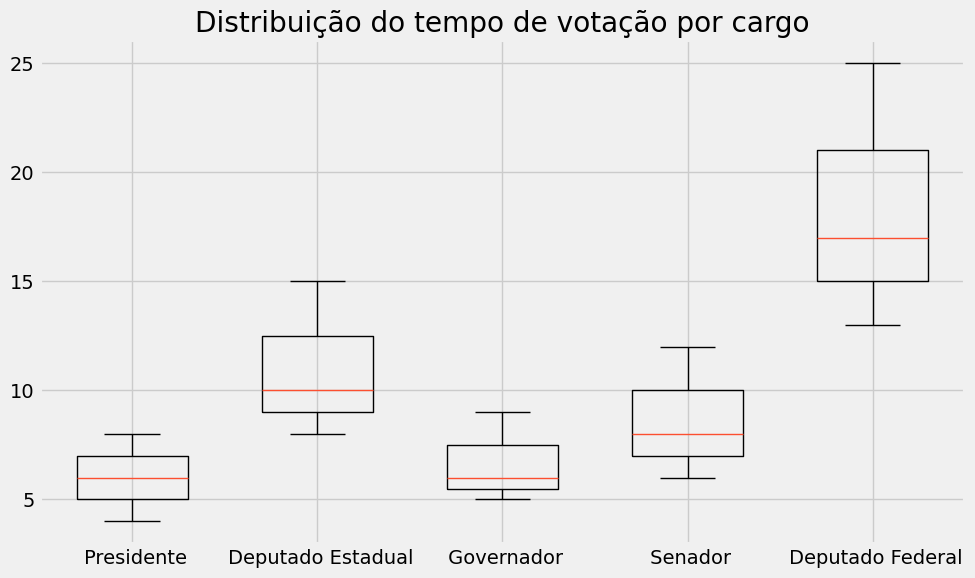

In [164]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 6))

for index, row in erro_por_cargo.iterrows():
    percentiles = [row["percentil_25"], row["percentil_50"], row["percentil_75"]]
    min_val = row["min"]
    max_val = row["max"]
    
    plt.boxplot([percentiles], positions=[index], widths=0.6, showfliers=False)


titulo = 'Distribuição do tempo de votação por cargo'
plt.xticks(erro_por_cargo.index, erro_por_cargo["descricao"])
plt.title(titulo)
plt.grid(True)
plt.tight_layout()
nome_arquivo = unidecode(titulo).lower().replace(" ", "_")
plt.savefig(f"app/img/box_{nome_arquivo}.jpg", format="jpg")
plt.show()
